# Курсовой проект

* [Подготовка данных](#Подготовка-данных)
    * [Обзор данных](#Обзор-данных)
    * [Обработка данных](#Обработка-данных)
    * [Отбор признаков](#Отбор-признаков)
* [Построение модели](#Построение-модели)
    * [Логистическая регрессия](#Логистическая-регрессия)
    * [XGBoost](#XGBoost)
    * [CatBoost](#CatBoost)
    * [Выбор модели](#Выбор-модели)
* [Прогнозирование](#Прогнозирование)

**Задача**

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Наименование файлов с данными**

course_project_train.csv - обучающий датасет<br>
course_project_test.csv - тестовый датасет

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1 > 0.5 при Precision > 0.5 и Recall > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

*Решение должно содержать*
1. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}\_solution.ipynb, пример SShirkin\_solution.ipynb
2. Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}\_predictions.csv, пример SShirkin\_predictions.csv

*Рекомендации для файла с кодом (ipynb)*
1. Файл должен содержать заголовки и комментарии (markdown)
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. Допускается применение библиотек Python и моделей машинного обучения,
которые были в данном курсе.

**Сроки сдачи**

Cдать проект нужно в течение 5 дней после окончания последнего вебинара.
Оценки работ, сданных до дедлайна, будут представлены в виде рейтинга, ранжированного по заданной метрике качества.
Проекты, сданные после дедлайна или сданные повторно, не попадают в рейтинг, но можно будет узнать результат.

# Библиотеки и функции

In [1]:
import pandas as pd
import numpy as np
import pickle
import random

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, classification_report, f1_score, precision_score, recall_score

from scipy.stats import chi2_contingency, mannwhitneyu


from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, plot_importance
from catboost import CatBoostClassifier


import seaborn as sns
from matplotlib import pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import warnings
warnings.simplefilter('ignore')

In [2]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print(f'TOTAL SCORE: {f1_score(y_test_true, y_test_pred)}\n')

In [3]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [4]:
def show_proba_calibration_plots(model, X_test, y_true_labels):
    a = model.predict_proba(X_test)
    y_predicted_probs = a[:, 1]
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (9, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [5]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(9,5))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [6]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (9, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [7]:
def cat_matrix(df, field, target):
    a = df[[field, target]]
    a['ID'] = a.index.tolist()
    b = a.pivot_table(values='ID', index=field, columns=target, aggfunc='count').reset_index()
    b.fillna(0, inplace=True)
    return b

def cat_stat(df, field, target):
    b = cat_matrix(df, field, target)
    b['Total'] = b[0] + b[1]
    b['%'] = b[1] / b['Total'] * 100
    
    total = {
        0: b[0].sum(), 
        1: b[1].sum(), 
        'Total': b['Total'].sum(),
        '%': b[1].sum() / b['Total'].sum() * 100,
        field: '-- Total --'
    }
    
    b = b.sort_values(by=['Total'], ascending=False).append(total, ignore_index=True).set_index(field)
    for i in [0, 1, 'Total', '%']:
        b[i] = b[i].astype(int)
    b.index.name=''
    b.columns.name=field
    return b

**Пути к директориям и файлам**

In [8]:
TRAIN_DATASET = 'course_project_train.csv'
TEST_DATASET = 'course_project_test.csv'

SCALER_PATH = 'scaler.pkl'
MODEL_PATH = 'model.pkl'

# Подготовка данных

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые льготы
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [9]:
df = pd.read_csv(TRAIN_DATASET)
dfBASE = df.copy()
df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


**Выделение целевой переменной и групп признаков**

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
Home Ownership                  7500 non-null object
Annual Income                   5943 non-null float64
Years in current job            7129 non-null object
Tax Liens                       7500 non-null float64
Number of Open Accounts         7500 non-null float64
Years of Credit History         7500 non-null float64
Maximum Open Credit             7500 non-null float64
Number of Credit Problems       7500 non-null float64
Months since last delinquent    3419 non-null float64
Bankruptcies                    7486 non-null float64
Purpose                         7500 non-null object
Term                            7500 non-null object
Current Loan Amount             7500 non-null float64
Current Credit Balance          7500 non-null float64
Monthly Debt                    7500 non-null float64
Credit Score                    5943 non-null float64
Credit Default                  7

In [11]:
TARGET_NAME = 'Credit Default'
CAT_FEATURES = list(df.select_dtypes(include='object').columns)
NUMERIC_FEATURES = df.columns.drop(CAT_FEATURES + [TARGET_NAME]).tolist()

## Обзор данных

#### Баланс классов в целевой переменной

In [12]:
df[TARGET_NAME].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

#### Количественные признаки

In [13]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
df[NUMERIC_FEATURES].describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
count,5943.00,7500.00,7500.00,7500.00,7500.00,7500.00,3419.00,7486.00,7500.00,7500.00,7500.00,5943.00
mean,1366391.72,0.03,11.13,18.32,945153.73,0.17,34.69,0.12,11873177.45,289833.24,18314.45,1151.09
std,845339.20,0.27,4.91,7.04,16026216.67,0.50,21.69,0.35,31926122.97,317871.38,11926.76,1604.45
min,164597.00,0.00,2.00,4.00,0.00,0.00,0.00,0.00,11242.00,0.00,0.00,585.00
25%,844341.00,0.00,8.00,13.50,279229.50,0.00,16.00,0.00,180169.00,114256.50,10067.50,711.00
50%,1168386.00,0.00,10.00,17.00,478159.00,0.00,32.00,0.00,309573.00,209323.00,16076.50,731.00
75%,1640137.00,0.00,14.00,21.80,793501.50,0.00,50.00,0.00,519882.00,360406.25,23818.00,743.00
max,10149344.00,7.00,43.00,57.70,1304726170.00,7.00,118.00,4.00,99999999.00,6506797.00,136679.00,7510.00


In [14]:
pd.set_option('display.float_format', None)
df.corr()[TARGET_NAME][:-1]

Annual Income                  -0.101375
Tax Liens                       0.024368
Number of Open Accounts         0.028884
Years of Credit History        -0.020567
Maximum Open Credit            -0.014275
Number of Credit Problems       0.020088
Months since last delinquent    0.002598
Bankruptcies                    0.001648
Current Loan Amount            -0.226522
Current Credit Balance         -0.019522
Monthly Debt                    0.018480
Credit Score                    0.442050
Name: Credit Default, dtype: float64

#### Категориальные признаки

In [15]:
for fld in CAT_FEATURES:
    print('-'*70, '\n', cat_stat(df, fld, TARGET_NAME),'\n\n')

---------------------------------------------------------------------- 
 Home Ownership     0     1  Total   %
                                     
Home Mortgage   2721   916   3637  25
Rent            2201  1003   3204  31
Own Home         455   192    647  29
Have Mortgage     10     2     12  16
-- Total --     5387  2113   7500  28 


---------------------------------------------------------------------- 
 Years in current job     0     1  Total   %
                                           
10+ years             1688   644   2332  27
2 years                512   193    705  27
3 years                450   170    620  27
< 1 year               404   159    563  28
5 years                371   145    516  28
1 year                 362   142    504  28
4 years                338   131    469  27
6 years                302   124    426  29
7 years                285   111    396  28
8 years                247    92    339  27
9 years                194    65    259  25
-- Total --  

## Обработка данных

In [16]:
df = dfBASE.copy()

### Выбросы

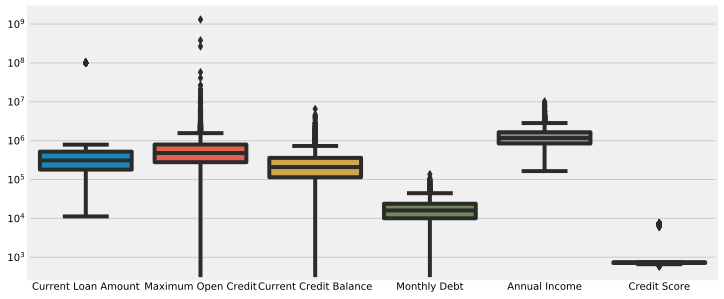

In [17]:
flds = ['Current Loan Amount', 'Maximum Open Credit', 
        'Current Credit Balance', 'Monthly Debt', 'Annual Income', 
        'Credit Score']
plt.figure(figsize=(11,5))
y = sns.boxplot(data=df[flds])
y.set_yscale("log")

In [18]:
def fix_emissions(df):
    medians = dfBASE.median()
    
#     em = [('Current Loan Amount', 1000000),
#           ('Maximum Open Credit', 2000000),
#           ('Current Credit Balance', 1000000),
#           ('Monthly Debt', 50000),
#           ('Annual Income', 4000000),
#          ]
    em = [('Current Loan Amount', 800000),
          ('Maximum Open Credit', 1000000),
          ('Current Credit Balance', 1000000),
          ('Monthly Debt', 50000),
          ('Annual Income', 2000000),
         ]    
    
    for i in em:
        fld, more = i
        bad = df[fld] > more
        df.loc[bad, fld] = medians[fld]

    # Errors in Credit Score
    bad = df['Credit Score'] > 5000
    df.loc[bad, 'Credit Score'] = df.loc[bad, 'Credit Score'] / 10

fix_emissions(df)

### Пропуски

In [19]:
a = len(df) - df.count()
a[a != 0]

Annual Income                   1557
Years in current job             371
Months since last delinquent    4081
Bankruptcies                      14
Credit Score                    1557
dtype: int64

Очень большой процент пропущенных значений для поля Months since last delinquent есть гипотеза что это поле может быть связано с полями Bankruptcies и Number of Credit Problems попробуем проанализировать и заполнить

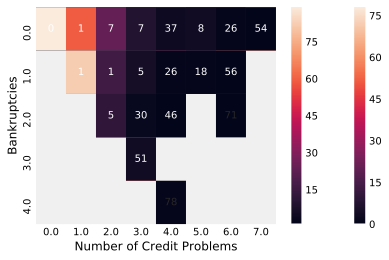

In [20]:
cnt = lambda x: len(x.unique())
a = "Months since last delinquent"
b = "Bankruptcies"
c = "Number of Credit Problems"
fill = df.pivot_table(a, b, c, aggfunc=np.min)
pivot = df.pivot_table(a, b, c, aggfunc=cnt)
sns.heatmap(fill, annot=True)
sns.heatmap(pivot)
plt.show()

Большой процент пропущенных значений для поля Annual Income есть гипотеза что это поле может быть связано с полями относящимися к выданному кредиту попробуем проанализировать и заполнить

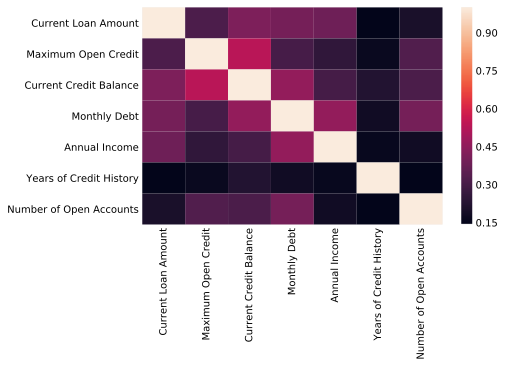

In [21]:
flds = ['Current Loan Amount', 'Maximum Open Credit', 'Current Credit Balance', 
        'Monthly Debt', 'Annual Income', 'Years of Credit History',
        'Number of Open Accounts']
sns.heatmap(df[flds].corr())
plt.show()

# хорошая корреляция с полем Monthly Debt будем использвать его для заполнения
a = df[(~df['Annual Income'].isnull()) & (df['Monthly Debt'] > 0)]
a = a['Annual Income'] / a['Monthly Debt']
ANNUAL_INCOME_MUL = float(a.median())

Большой процент пропущенных значений для поля Credit Score есть гипотеза что это поле может быть связано с полями относящимися к выданному кредиту попробуем проанализировать и заполнить

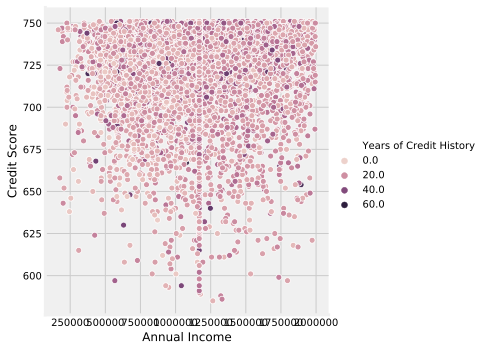

In [22]:
flds = ['Annual Income', 'Credit Score', 'Years of Credit History']
flt = (~df['Annual Income'].isnull()) & (~df['Credit Score'].isnull()) 
sns.relplot(y='Credit Score', x='Annual Income', hue='Years of Credit History', data=df[flt])

# из графика видно что нет никакой зависимости будем использовать median для заполнения

CREDIT_SCORE_DEFAULT = float(df[flt]['Credit Score'].median())

In [23]:
def fix_empty(df):
    df['Bankruptcies'].fillna(0, inplace=True)

    fld = 'Months since last delinquent'
    bad = (df[fld].isnull()) & ((df['Bankruptcies']>0) | (df['Number of Credit Problems'] > 0))
    df.loc[bad, fld] = 1
    df[fld].fillna(0, inplace=True)
    
#     ifAnual = df['Years in current job'].isnull() & df['Annual Income'] > 0
#     df.loc[ifAnual, 'Years in current job'] = 1
    df['Years in current job'].fillna(0, inplace=True)

    fld = 'Annual Income'
    bad = df[fld].isnull()
    df.loc[bad, fld] = df.loc[bad, 'Monthly Debt'] * ANNUAL_INCOME_MUL
    
    fld = 'Credit Score'
    bad = df[fld].isnull()
    df.loc[bad, fld] = CREDIT_SCORE_DEFAULT

fix_empty(df)

In [24]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
df[NUMERIC_FEATURES].describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
count,7500.00,7500.00,7500.00,7500.00,7500.00,7500.00,7500.00,7500.00,7500.00,7500.00,7500.00,7500.00
mean,1128900.62,0.03,11.13,18.32,449008.84,0.17,15.89,0.12,309088.03,253853.83,17353.97,721.94
std,452420.06,0.27,4.91,7.04,222319.11,0.50,22.60,0.35,171393.74,193851.46,9867.91,25.15
min,0.00,0.00,2.00,4.00,0.00,0.00,0.00,0.00,11242.00,0.00,0.00,585.00
25%,814784.63,0.00,8.00,13.50,279229.50,0.00,0.00,0.00,180169.00,114256.50,10067.50,715.00
50%,1151286.00,0.00,10.00,17.00,478153.50,0.00,1.00,0.00,309567.50,209313.50,16075.75,729.00
75%,1390275.04,0.00,14.00,21.80,571714.00,0.00,29.00,0.00,396929.50,338314.00,23022.75,738.00
max,3277795.42,7.00,43.00,57.70,999790.00,7.00,118.00,4.00,789030.00,997899.00,49997.00,751.00


In [25]:
pd.set_option('display.float_format', None)

### Преобразование

In [26]:
def convert_year(df):
    import re
    df['Years in current job'] = df['Years in current job'].apply(lambda x: int(re.sub(r'\D+', '', str(x))))
    df['Years in current job'] = df['Years in current job'].astype(int)


convert_year(df)

### Выбросы категориальных признаков

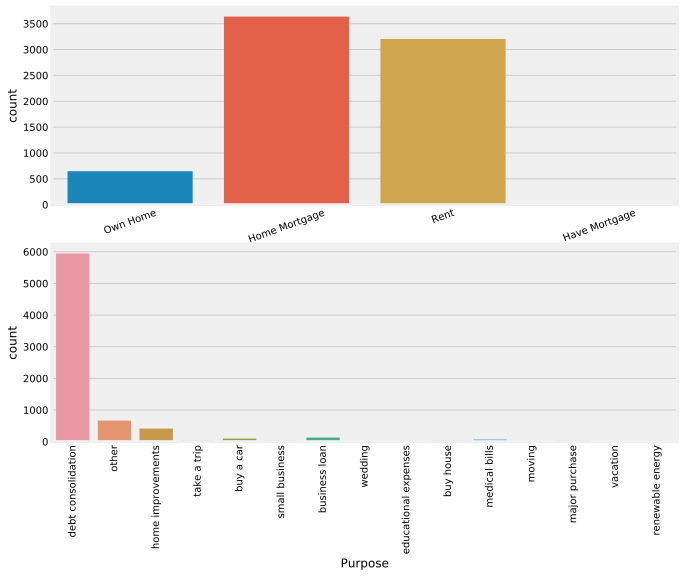

In [27]:
plt.figure(figsize=(10, 8))
ax = plt.subplot(211)
sns.countplot(x='Home Ownership', data=df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=20)
ax = plt.subplot(212)
sns.countplot(x='Purpose', data=df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

In [28]:
def fix_cat_emissions(df, fld):
    a = df[fld].value_counts()
    a.sort_values(ascending=False)
    value = a.index[0]
    good = a[a>100].index.tolist()
    flt = ~df[fld].isin(good)
    df.loc[flt, fld] = value


fix_cat_emissions(df, 'Home Ownership')
fix_cat_emissions(df, 'Purpose')

## Отбор признаков

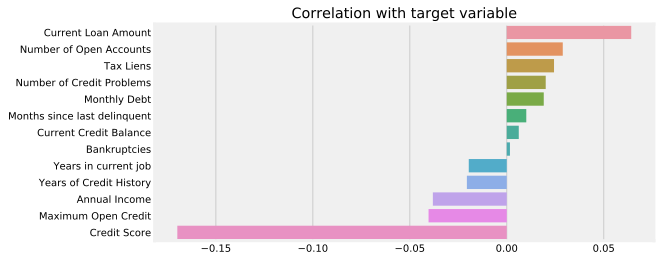

In [29]:
corr_with_target = df.corr().iloc[:-1, -1].sort_values(ascending=False)
plt.figure(figsize=(8, 4))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index)
plt.title('Correlation with target variable')
plt.show()

NUMERIC_FEATURES = df.corr().iloc[:-1, -1].index

### Анализ категориальных признаков

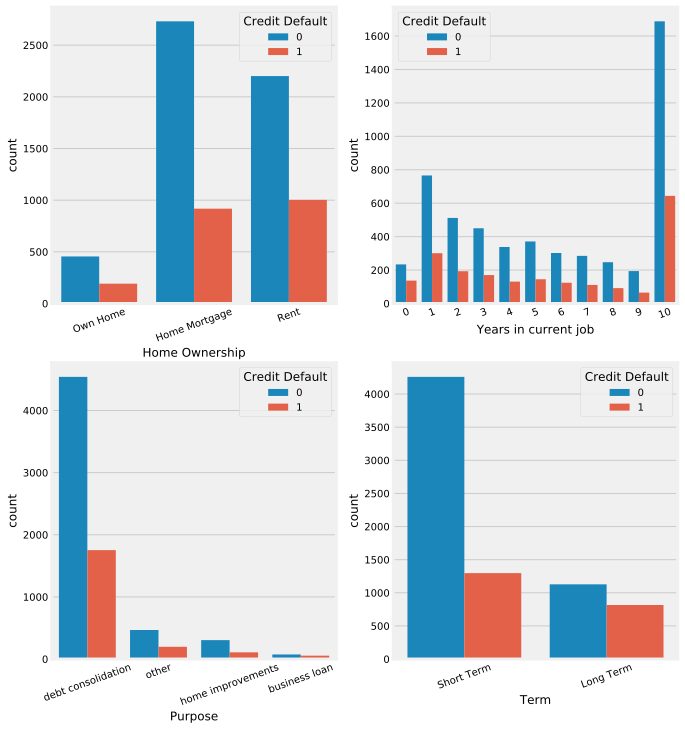

In [30]:
plt.figure(figsize=(10, 12))

c = 0
for i in CAT_FEATURES:
    ax = plt.subplot(221 + c)
    sns.countplot(x=i, hue=TARGET_NAME, data=df)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=20)
    c += 1

plt.show()

In [31]:
fld = 'Home Ownership'
flt = df[fld].isin(['Home Mortgage', 'Own Home'])
table = df.loc[flt, [fld, TARGET_NAME]].sample(1000).reset_index() \
            .pivot_table(values='index', index=fld, columns=TARGET_NAME, aggfunc='count')
chi2, p, dof, expected = chi2_contingency(table, correction=False)
p

0.7364845868518746

In [32]:
fld = 'Purpose'
flt = df[fld].isin(['other', 'home improvements'])

table = df.loc[flt, [fld, TARGET_NAME]].sample(1000).reset_index() \
            .pivot_table(values='index', index=fld, columns=TARGET_NAME, aggfunc='count')
chi2, p, dof, expected = chi2_contingency(table, correction=False)
p

0.2783561765315883

**можно сделать вывод что можно сузить набор значений для категориальных признаков до двух и подготовить dummies**

In [33]:
def reduce_cat_values(df):
    return
    fld = 'Home Ownership'
    flt = df[fld] != 'Rent'
    df.loc[flt, fld] = 'Home Mortgage'

    fld = 'Purpose'
    flt = df[fld] != 'debt consolidation'
    df.loc[flt, fld] = 'other'


reduce_cat_values(df)

### Анализ числовых признаков

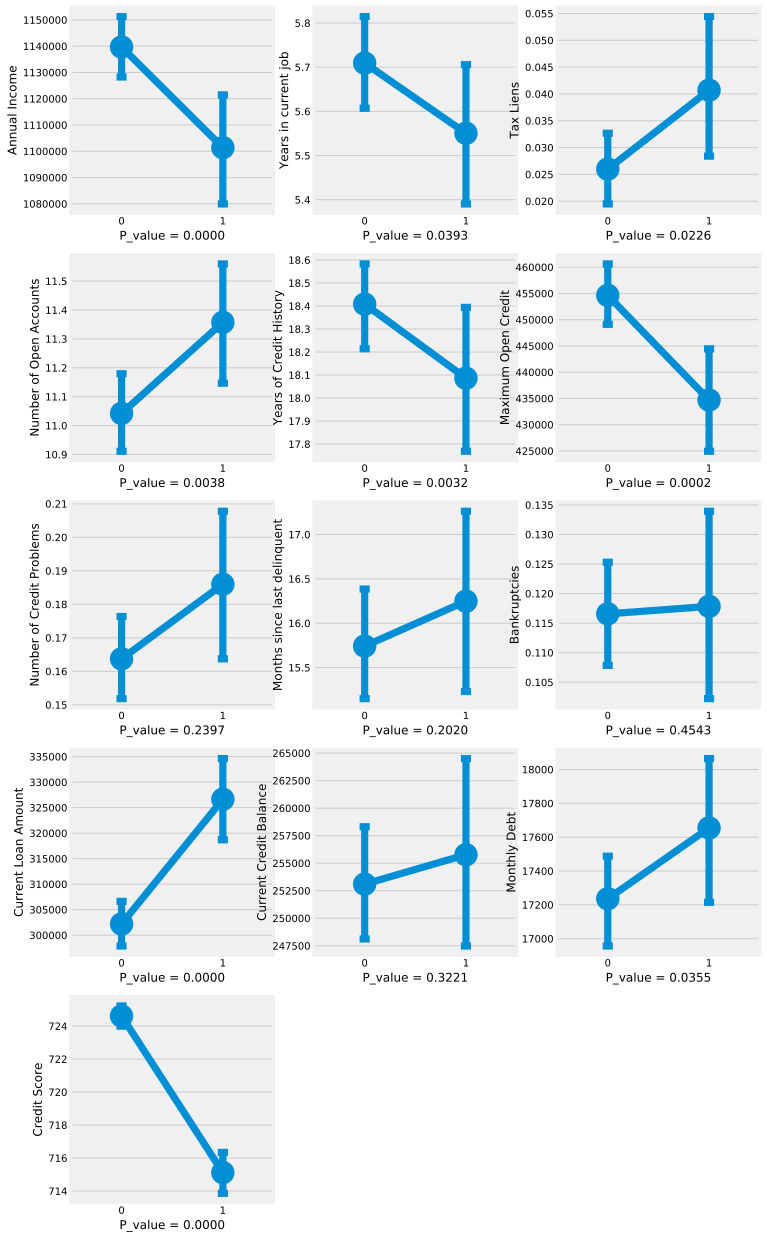

In [34]:
plt.figure(figsize=(11, 22))

c = 0
k = 0
for i in NUMERIC_FEATURES:
    ax = plt.subplot2grid((5,3), (k, c))
    sns.pointplot(x=TARGET_NAME, y=i, data=df, capsize=.1)
    
    a = df[[i, TARGET_NAME]]
    c_0 = a[a[TARGET_NAME] == 0][i]
    c_1 = a[a[TARGET_NAME] == 1][i]
    s, p = mannwhitneyu(c_0, c_1)
    
    
    ax.set_xlabel(f'P_value = {p:0.4f}')
    c += 1
    if c>2:
        k += 1
        c = 0
plt.show()

#### Корреляция признаков

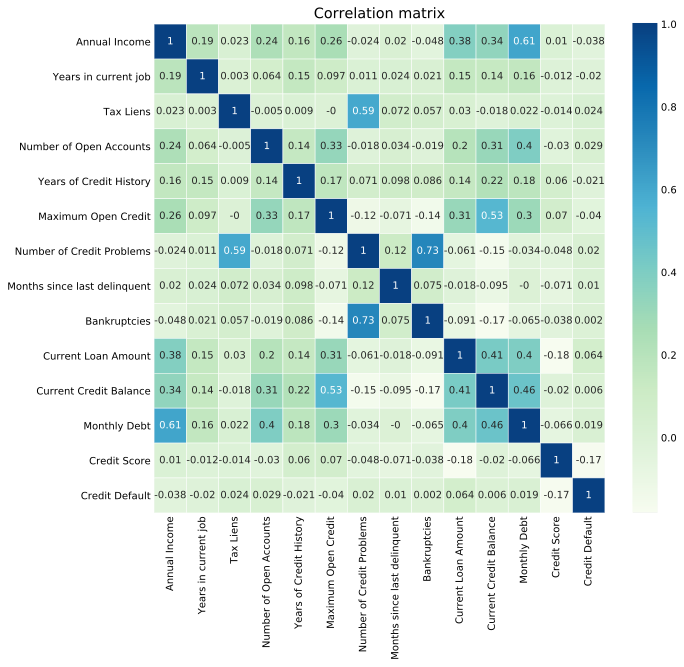

In [35]:
plt.figure(figsize=(9, 9))
sns.heatmap(df.corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

### Итоговая подготовка признаков

**на основе этих графиков и Pvalue возможно стоит чтото сделать с признаками:**
* Current Credit Balance - высокое PValue и большая корреляция с другими - не будем его учитывать вообще
* Bankruptcies - очень слабый признак стоит проверить может его перевести в синтетический
* Number of Credit Problems - сильно связан с предидущим возмжно стоит его проанализировать вместе с ним и не использовать его
* Tax Liens - нужно убрать связь с предидущим а сам по себе можно оставить
* Months since last delinquent - возможно стоит перевести в категориальный 

In [36]:
def convert_fields(df):
    return
    fld = 'isNotDelinquent'
    df[fld] = df['Months since last delinquent'] > 0
    df[fld] = df[fld].astype(int)
    
    fld = 'Credit Problems'
    df[fld] = df['Number of Credit Problems'] * df['Bankruptcies']
    df[fld] = df[fld] > 0
    df[fld] = df[fld].astype(int)

convert_fields(df)

In [37]:
SYNTETIC = [
#     'Credit Problems',
#     'isNotDelinquent',
]

DONT_USE_FIELDS = [
    
    'Current Credit Balance',
    'Bankruptcies',
#     'Number of Credit Problems',
#     'Months since last delinquent',
    
#     'Maximum Open Credit',
#     'Monthly Debt',
#     'Years in current job',
    
#     'Tax Liens',
#     'Number of Open Accounts',
#     'Years of Credit History',
    
    
] + SYNTETIC

In [38]:
CAT_FEATURES = list(df.select_dtypes(include='object').columns)
temp = list(df.columns.drop(CAT_FEATURES + [TARGET_NAME]).tolist())
NUMERIC_FEATURES = [element for element in temp if element not in DONT_USE_FIELDS]

### Нормализация данных

In [39]:
scaler = StandardScaler()
df[NUMERIC_FEATURES] = scaler.fit_transform(df[NUMERIC_FEATURES])

### Создание dummies и подготовка признаков

In [40]:
ndf = pd.get_dummies(df)
NEW_FEATURES = SYNTETIC + list(ndf.columns.drop(NUMERIC_FEATURES + DONT_USE_FIELDS + [TARGET_NAME]).tolist())
SELECTED_FEATURES = NUMERIC_FEATURES + NEW_FEATURES

cdf = df.copy()
SELECTED_FEATURES_CAT = NUMERIC_FEATURES + CAT_FEATURES + SYNTETIC

# Построение модели

### Разбиение на train и test

In [41]:
def balance_df_by_target_under(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    
    percent = (1 - target_counts[minor_class_name] / target_counts[major_class_name]) / 2
    
    res = df[df[target_name] == major_class_name].sample(frac=(1 - percent))
    res = res.append(df[df[target_name] == minor_class_name])
    
    cnts = int((df[TARGET_NAME].count() - res[TARGET_NAME].count()) * 0.8)
    sample = df[df[target_name] == minor_class_name].sample(cnts)
    res = res.append(sample)
    return res

In [42]:
def split_data(data, features, target):
    X = data[features]
    y = data[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.25, random_state=211)
    
    df_for_balancing = pd.concat([X_train, y_train], axis=1)
    df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
    X_train = df_balanced.drop(columns=TARGET_NAME)
    y_train = df_balanced[TARGET_NAME]
    
    return (X_train, X_test, y_train, y_test)

In [43]:
def findModel(mclass, params, X_train, y_train, X_test, y_test, n_splits=5, n_iter=10, grid=False):
    model = mclass()
    cv=KFold(n_splits=n_splits, random_state=21, shuffle=True)
    
    if grid:
        rs = GridSearchCV(model, params, scoring='f1', cv=cv, n_jobs=-1)
        rs.fit(X_train, y_train)
    else:
        rs = RandomizedSearchCV(model, params, scoring='f1', cv=cv, n_jobs=-1, n_iter=n_iter)
        rs.fit(X_train, y_train)
    
    model = mclass(**rs.best_params_)
    model.fit(X_train, y_train)
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)
    print('BEST PARAMS: \n', model.get_params())
    return (model, rs, y_test_pred)

In [44]:
X_train, X_test, y_train, y_test = split_data(ndf, SELECTED_FEATURES, TARGET_NAME)
Xc_train, Xc_test, yc_train, yc_test = split_data(cdf, SELECTED_FEATURES_CAT, TARGET_NAME)

## Логистическая регрессия

In [45]:
%%time

params = {
    'random_state': [21], 
    'class_weight': ['balanced'],
    'tol': [0.0001, 1e-6, 1e-9, 1e-17],
    'penalty': ['l2'],
    'C': np.logspace(-2,2,100),
    'n_jobs': [-1]
}

model, rs, y_test_pred = findModel(LogisticRegression, params, X_train, y_train, X_test, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.66      0.67      0.67      4047
           1       0.57      0.56      0.57      3156

   micro avg       0.62      0.62      0.62      7203
   macro avg       0.62      0.62      0.62      7203
weighted avg       0.62      0.62      0.62      7203

TEST

              precision    recall  f1-score   support

           0       0.78      0.64      0.71      1340
           1       0.38      0.56      0.46       535

   micro avg       0.62      0.62      0.62      1875
   macro avg       0.58      0.60      0.58      1875
weighted avg       0.67      0.62      0.63      1875

TOTAL SCORE: 0.4554455445544554

BEST PARAMS: 
 {'C': 0.093260334688322, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 100, 'multi_class': 'warn', 'n_jobs': -1, 'penalty': 'l2', 'random_state': 21, 'solver': 'warn', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
CPU times: 

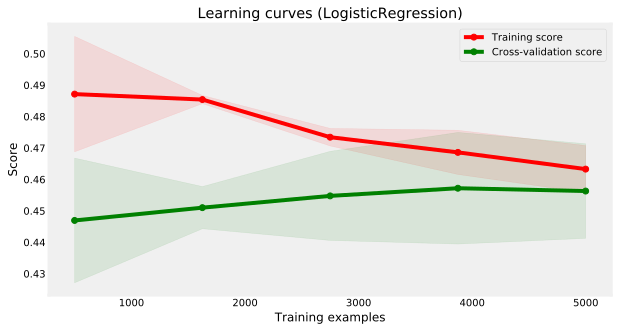

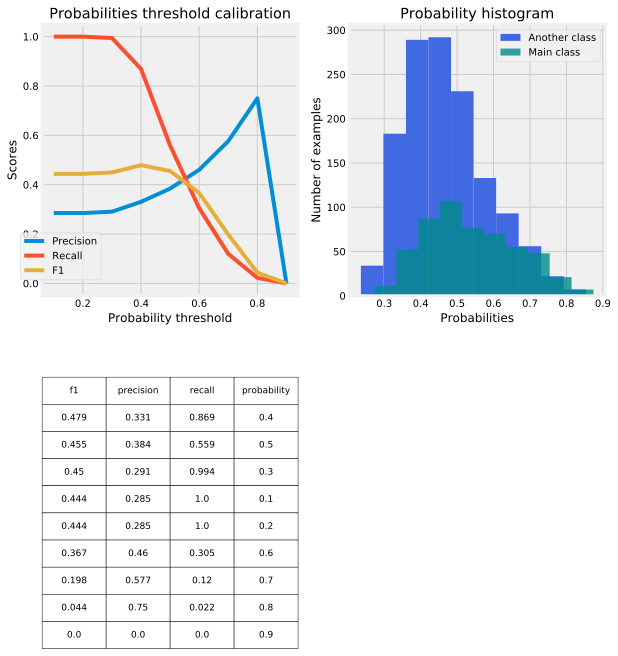

In [46]:
X = ndf[SELECTED_FEATURES]
y = ndf[TARGET_NAME]
show_learning_curve_plot(model, X, y)
show_proba_calibration_plots(model, X_test, y_test)

## XGBoost

In [47]:
%%time

params = {
    'random_state': [21],
    'n_jobs': [-1],
#     'n_estimators': [100], 
#     'max_depth': [3, 4],
#     'learning_rate': [0.05, 0.1],
    'reg_lambda': range(10, 20),
}

model, rs, y_test_pred = findModel(XGBClassifier, params, X_train, y_train, X_test, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.72      0.76      0.74      4047
           1       0.67      0.63      0.65      3156

   micro avg       0.70      0.70      0.70      7203
   macro avg       0.70      0.69      0.69      7203
weighted avg       0.70      0.70      0.70      7203

TEST

              precision    recall  f1-score   support

           0       0.80      0.72      0.76      1340
           1       0.44      0.55      0.49       535

   micro avg       0.67      0.67      0.67      1875
   macro avg       0.62      0.63      0.62      1875
weighted avg       0.70      0.67      0.68      1875

TOTAL SCORE: 0.4872006606110652

BEST PARAMS: 
 {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'n_jobs': -1, 'nthread': None, 'objective'

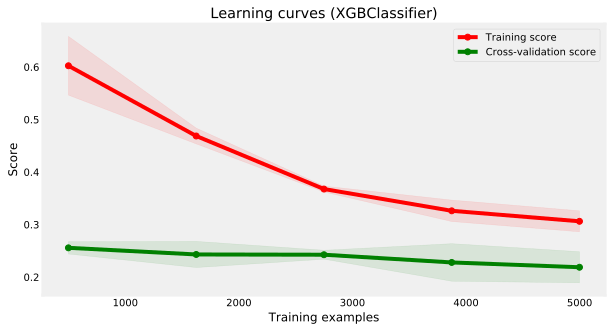

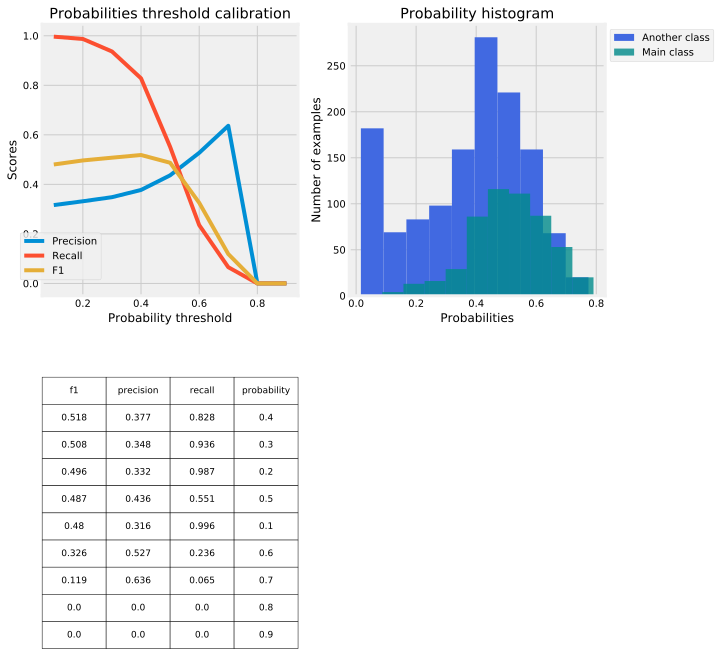

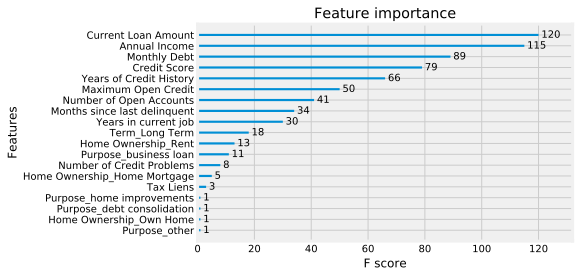

In [48]:
X = ndf[SELECTED_FEATURES]
y = ndf[TARGET_NAME]
show_learning_curve_plot(model, X, y)
show_proba_calibration_plots(model, X_test, y_test)
plot_importance(model)
plt.show()

## CatBoost

In [49]:
%%time

params = {
    'random_state': [21],
    'silent': [True],
    'cat_features':[CAT_FEATURES],
    'class_weights': [[1, 2], [1, 3]],
    'reg_lambda': [10, 20],
    'iterations': [500],
    'one_hot_max_size': [10],
}


model, rs, y_test_pred = findModel(CatBoostClassifier, params, Xc_train, yc_train, Xc_test, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.95      0.50      0.66      4047
           1       0.60      0.97      0.74      3156

   micro avg       0.70      0.70      0.70      7203
   macro avg       0.78      0.73      0.70      7203
weighted avg       0.80      0.70      0.69      7203

TEST

              precision    recall  f1-score   support

           0       0.88      0.42      0.57      1340
           1       0.37      0.86      0.52       535

   micro avg       0.55      0.55      0.55      1875
   macro avg       0.63      0.64      0.55      1875
weighted avg       0.74      0.55      0.56      1875

TOTAL SCORE: 0.5192743764172335

BEST PARAMS: 
 {'iterations': 500, 'silent': True, 'class_weights': [1, 2], 'one_hot_max_size': 10, 'random_state': 21, 'reg_lambda': 10, 'cat_features': ['Home Ownership', 'Purpose', 'Term']}
CPU times: user 35.3 s, sys: 6.06 s, total: 41.4 s
Wall time: 2min 56s


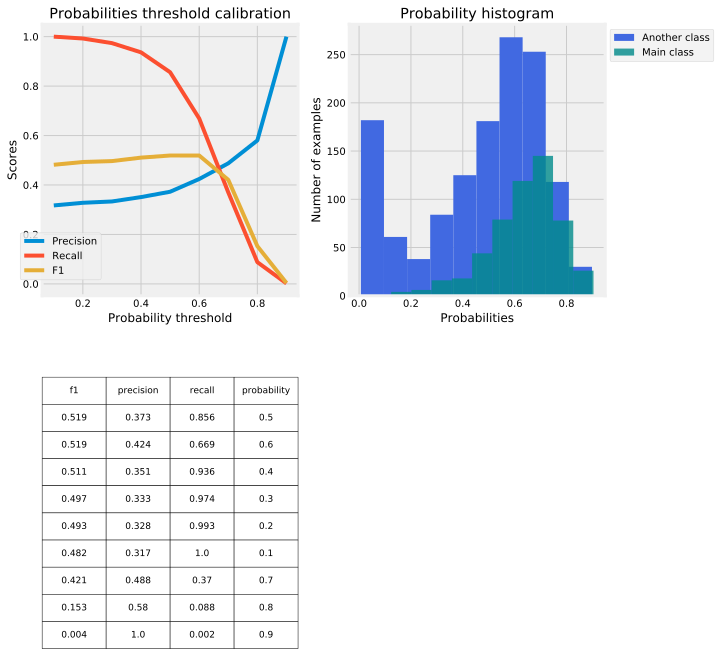

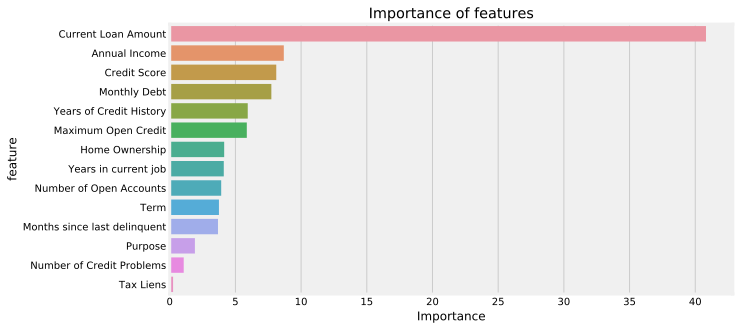

In [50]:
show_proba_calibration_plots(model, Xc_test, yc_test)
show_feature_importances(Xc_train.columns, model.feature_importances_)

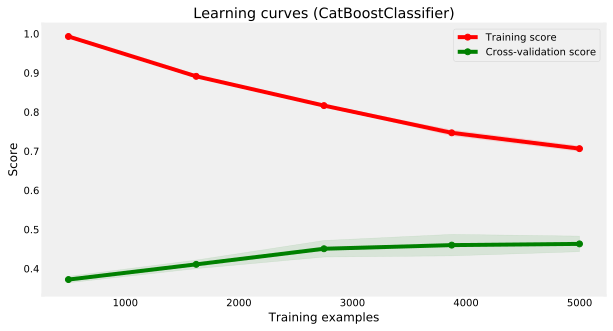

In [51]:
X = cdf[SELECTED_FEATURES_CAT]
y = cdf[TARGET_NAME]
show_learning_curve_plot(model, X, y)

## Выбор модели

Наилучшие результаты показала модель бустинга CatBoost, кроме того она умеет удобно работать с категориальными признаками поэтому остановимся на ней

# Прогнозирование

### Проверим все этапы очистки и построения модели

In [52]:
df = dfBASE.copy()
pd.set_option('display.float_format', lambda x: '%.2f' % x)
df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5943.00,7500.00,7500.00,7500.00,7500.00,7500.00,3419.00,7486.00,7500.00,7500.00,7500.00,5943.00,7500.00
mean,1366391.72,0.03,11.13,18.32,945153.73,0.17,34.69,0.12,11873177.45,289833.24,18314.45,1151.09,0.28
std,845339.20,0.27,4.91,7.04,16026216.67,0.50,21.69,0.35,31926122.97,317871.38,11926.76,1604.45,0.45
min,164597.00,0.00,2.00,4.00,0.00,0.00,0.00,0.00,11242.00,0.00,0.00,585.00,0.00
25%,844341.00,0.00,8.00,13.50,279229.50,0.00,16.00,0.00,180169.00,114256.50,10067.50,711.00,0.00
50%,1168386.00,0.00,10.00,17.00,478159.00,0.00,32.00,0.00,309573.00,209323.00,16076.50,731.00,0.00
75%,1640137.00,0.00,14.00,21.80,793501.50,0.00,50.00,0.00,519882.00,360406.25,23818.00,743.00,1.00
max,10149344.00,7.00,43.00,57.70,1304726170.00,7.00,118.00,4.00,99999999.00,6506797.00,136679.00,7510.00,1.00


In [53]:
def prepare(df):
    fix_emissions(df)
    fix_empty(df)
    convert_year(df)
    fix_cat_emissions(df, 'Home Ownership')
    fix_cat_emissions(df, 'Purpose')
    reduce_cat_values(df)
    convert_fields(df)
    df[NUMERIC_FEATURES] = scaler.transform(df[NUMERIC_FEATURES])
    return df

In [54]:
prepare(df)
df.describe()

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,7500.00,7500.00,7500.00,7500.00,7500.00,7500.00,7500.00,7500.00,7500.00,7500.00,7500.00,7500.00,7500.00,7500.00
mean,0.00,-0.00,-0.00,0.00,-0.00,-0.00,0.00,0.00,0.12,-0.00,253853.83,-0.00,0.00,0.28
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.35,1.00,193851.46,1.00,1.00,0.45
min,-2.50,-1.55,-0.11,-1.86,-2.03,-2.02,-0.34,-0.70,0.00,-1.74,0.00,-1.76,-5.45,0.00
25%,-0.69,-1.00,-0.11,-0.64,-0.68,-0.76,-0.34,-0.70,0.00,-0.75,114256.50,-0.74,-0.28,0.00
50%,0.05,0.09,-0.11,-0.23,-0.19,0.13,-0.34,-0.66,0.00,0.00,209313.50,-0.13,0.28,0.00
75%,0.58,1.19,-0.11,0.58,0.49,0.55,-0.34,0.58,0.00,0.51,338314.00,0.57,0.64,1.00
max,4.75,1.19,25.66,6.49,5.59,2.48,13.70,4.52,4.00,2.80,997899.00,3.31,1.16,1.00


In [55]:
X_train, X_test, y_train, y_test = split_data(df, SELECTED_FEATURES_CAT, TARGET_NAME)

In [56]:
model = CatBoostClassifier(**rs.best_params_)
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.96      0.50      0.66      4047
           1       0.60      0.97      0.75      3156

   micro avg       0.71      0.71      0.71      7203
   macro avg       0.78      0.74      0.70      7203
weighted avg       0.80      0.71      0.70      7203

TEST

              precision    recall  f1-score   support

           0       0.88      0.42      0.57      1340
           1       0.37      0.86      0.52       535

   micro avg       0.55      0.55      0.55      1875
   macro avg       0.63      0.64      0.54      1875
weighted avg       0.73      0.55      0.56      1875

TOTAL SCORE: 0.5180995475113122



### Обучим модель на полной выборке

In [57]:
df = dfBASE.copy()
prepare(df)

X_train = df[SELECTED_FEATURES_CAT]
y_train = df[TARGET_NAME]

df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)

X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]


model = CatBoostClassifier(**rs.best_params_)
model.fit(X_train, y_train)

### Загрузим тестовые и сделаем предсказание

In [58]:
df = pd.read_csv(TEST_DATASET)
df.head()

,Id,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,7500,Rent,nan,4 years,0.00,9.00,12.50,220968.00,0.00,70.00,0.00,debt consolidation,Short Term,162470.00,105906.00,6813.00,nan
1,7501,Rent,231838.00,1 year,0.00,6.00,32.70,55946.00,0.00,8.00,0.00,educational expenses,Short Term,78298.00,46037.00,2318.00,699.00
2,7502,Home Mortgage,1152540.00,3 years,0.00,10.00,13.70,204600.00,0.00,nan,0.00,debt consolidation,Short Term,200178.00,146490.00,18729.00,7260.00
3,7503,Home Mortgage,1220313.00,10+ years,0.00,16.00,17.00,456302.00,0.00,70.00,0.00,debt consolidation,Short Term,217382.00,213199.00,27559.00,739.00
4,7504,Home Mortgage,2340952.00,6 years,0.00,11.00,23.60,1207272.00,0.00,nan,0.00,debt consolidation,Long Term,777634.00,425391.00,42605.00,706.00


In [59]:
prepare(df)
X_test = df[SELECTED_FEATURES_CAT]
df['Credit Default'] = model.predict(X_test)

In [60]:
df['Credit Default'] = df['Credit Default'].astype(int)
df.loc[:,['Id','Credit Default']].to_csv('SAhranovich_predictions.csv', index=None)

### Сохранение модели<a class="anchor" id="saving_model"></a> 

**Scaler**

In [63]:
with open(SCALER_PATH, 'wb') as file:
    pickle.dump(scaler, file)

**Model**

In [64]:
with open(MODEL_PATH, 'wb') as file:
    pickle.dump(model, file)